<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Nicolás Acevedo
- Nombre de alumno 2: Fabiola Pizarro


### **Link de repositorio de GitHub:** `https://github.com/nicoacevedor/MDS7202`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

### Librerías a utilizar

In [2]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [3]:
df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [4]:
variable_columns = list(set(df.columns) - set(['Diabetes']))

transformer = FunctionTransformer(lambda df: df.dropna())
scaler = ColumnTransformer([('MinMax', MinMaxScaler(), variable_columns)], verbose_feature_names_out=False)
predictor = XGBClassifier()

pipeline = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('predictor', predictor)
])

In [5]:
X = df[variable_columns]
y = df['Diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Error absoluto medio: 0.251
False Negative Rate: 0.209
F1 Score: 0.759


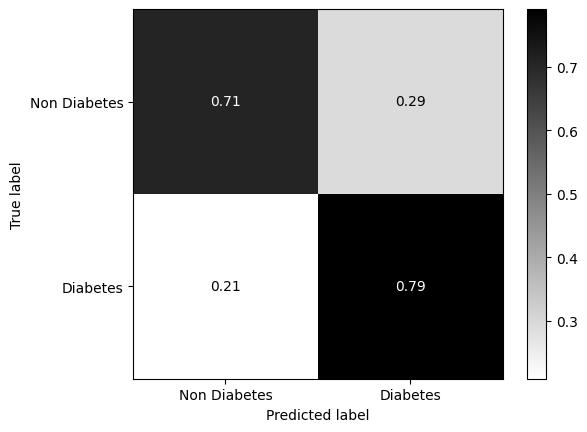

In [6]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred, normalize='true')

tn, fp, fn, tp = cm.ravel()
print(f"Error absoluto medio: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"False Negative Rate: {(fn/(fn + tp)):.3f}")
print(f"F1 Score: {(2*tp/(2*tp + fp + fn)):.3f}")

disp = ConfusionMatrixDisplay(cm, display_labels=['Non Diabetes', 'Diabetes'])
plot = disp.plot(cmap="binary")

El `MAE` del modelo es bastante bajo, lo que indica que está bien entrenado. Así mismo, el valor del `F1-Score` es bastante bueno, aproximadamente 0.76. Pero dado que estamos hablando de una enfermedad, se quieren evitar los falsos negativos porque eso significaría no diagnosticarla. Al usar la métrica `False Negative Rate`, estamos midiendo cual es la proporción de predicciones de no diabetes dado que el modelo predijo que no había diabetes, lo cual tiene un valor de 0.209. Esto quiere decir que aproximadamente el 20% de las predicciones de personas sanas están incorrectas. Consideramos que no es un buen predictor de diabetes ya que a pesar de estar bien entrenado y que las otras métricas dan buenos resultados, en el largo plazo este no diagnosticaría al 20% con diabetes, siendo que tiene diabetes.

Estas métricas no permiten saber si el modelo está haciendo una buena selección de las features, ya que en ellas solo se considera la predicción, nada del orden o ponderación de las features.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [7]:
# Primero se obtiene la importancia de las características
feature_importance_weight = predictor.get_booster().get_score(importance_type='weight')
feature_importance_cover = predictor.get_booster().get_score(importance_type='cover')
feature_importance_gain = predictor.get_booster().get_score(importance_type='gain')


# Luego se redondea y se colocan los nombres de las columnas
rounded_weight = {variable_columns[int(key[1:])]: np.round(val, 2) for key, val in feature_importance_weight.items()}
rounded_cover = {variable_columns[int(key[1:])]: np.round(val, 2) for key, val in feature_importance_cover.items()}
rounded_gain = {variable_columns[int(key[1:])]: np.round(val, 2) for key, val in feature_importance_gain.items()}

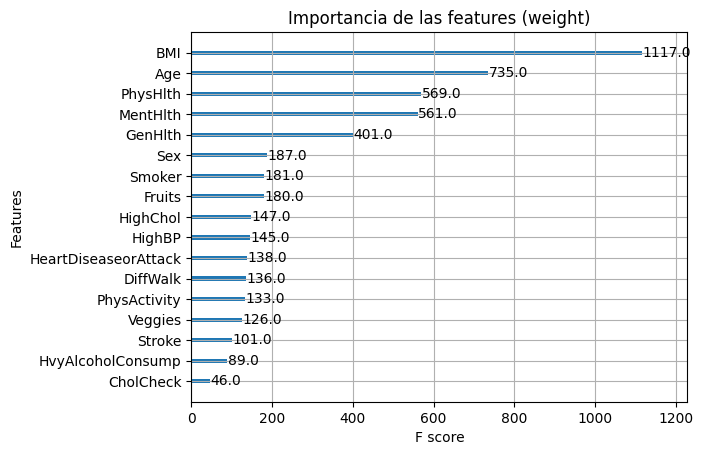

In [8]:
# Gráfico para weight
xgb.plot_importance(rounded_weight, max_num_features=20)
plt.title("Importancia de las features (weight)")
plt.show()

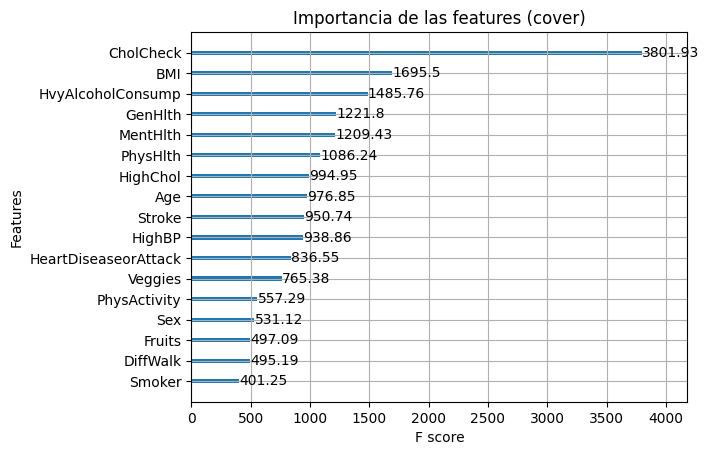

In [9]:
# Gráfico para cover
xgb.plot_importance(rounded_cover, max_num_features=20)
plt.title("Importancia de las features (cover)")
plt.show()

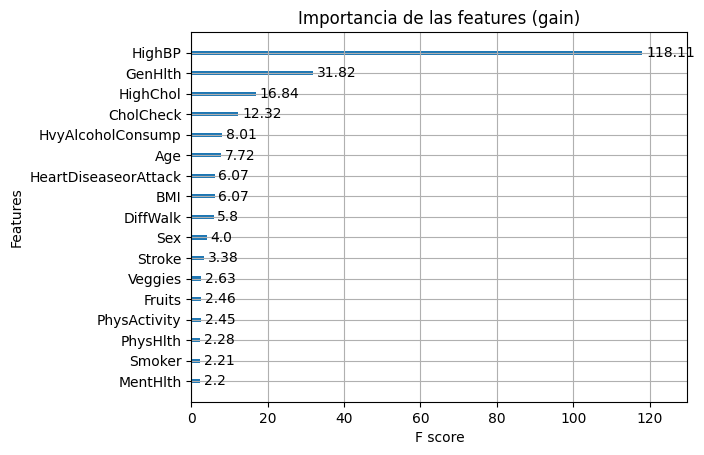

In [10]:
# Gráfico para gain
xgb.plot_importance(rounded_gain, max_num_features=20)
plt.title("Importancia de las features (gain)")
plt.show()

Para analizar los resultados es importante recordar que cada uno de los métodos proporciona una perspectiva diferente sobre cómo las características afectan la predicción del modelo:

- **Weight:** hace referencia al número de veces que una característica aparece en todos los árboles del modelo, por lo que es una métrica basada en la frecuencia con la que se utiliza una característica para tomar decisiones en los árboles. Cuanto más se utiliza una característica para tomar decisiones, mayor será su peso.
- **Cover:** hace referencia a la cantidad de datos que son influenciados por una característica en todos los árboles del modelo. Mide la cantidad total de observaciones (instancias de datos) que se ven afectadas por las divisiones utilizadas en una característica. Mientras mayor sea el cover, se indica que se tiene un impacto más amplio en la toma de decisiones en el modelo
- **Gain:** mide la importancia de una característica considerando la mejora en la precisión del modelo cuando se utiliza esa característica para tomar decisiones en los árboles. De esta forma, la importancia de las características obtenida por gain se basa en la utilidad que aporta cada característica a la precisión del modelo, considerando la ganancia en la función de pérdida.

Del gráfico asociado a weight se ve que la feature con mayor importancia es *BMI* (Índice de Masa Corporal), seguida por la *edad* y *PhysHlth* (salud física). Mientras que del gráfico asociado a cover se ve que *CholCheck* (control de colesterol) es aquella con mayor importancia, seguida por *BMI* y *HvyAlcoholConsump* (consumo alto de alcohol). Por otro lado, del gráfico gain se obtuvo que *HighBP* (presión arterial alta) fue la feature con mayor importancia, seguida por *GenHlth* (salud general) y *HighChol* (colesterol alto), respectivamente.

De los resultados, se ve que son distintas las features que ocupan los primeros lugares en el ranking de importancia, siendo BMI la única feature que se ve en 2 rankings distintos (weight y cover). Pero esta desigualdad que se obtiene con los distintos métodos no implica necesariamente una incompatibilidad, ya que las diferencias en las características de mayor importancia pueden ocurrir debido a la manera en que cada métrica mide la importancia de las características, como se mencionó anteriormente. Por ejemplo, BMI podría ser una característica de alta importancia según el método de weight porque se utiliza con frecuencia en la toma de decisiones de los árboles. Sin embargo, CholCheck podría tener una alta importancia en cover debido a la amplia cobertura de datos afectados por sus divisiones, y HighBP podría ser más importante en gain debido a la mejora que aporta a la precisión del modelo.

Las importancias obtenidas son de utilidad para comprender las features que más influyen en el modelo de acuerdo a distintos parámetros, sin embargo, no es suficiente para obtener la interpretabilidad del modelo. Para obtener una interpretación más sólida y completa, es recomendable complementar este tipo de análisis con otras técnicas, las cuales permitan obtener información más detallada del modelo, la relación entre las características y sus efectos en las predicciones del modelo.

Una de las debilidades de este método es que no revela la dirección precisa de la influencia de una característica en la predicción. Además, las importancias podrían verse afectadas por el sesgo inherente al conjunto de datos. Las características altamente correlacionadas pueden tener importancias muy similares o pueden aparecer características importantes solo porque están correlacionadas con otras realmente importantes. Lo cual reafirma la importancia de complementar este método con otras técnicas para dar una interpretabilidad completa al modelo.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [11]:
# Se calculan los resultados
result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)
result

{'importances_mean': array([0.0015937 , 0.0157319 , 0.00434496, 0.05654101, 0.00072377,
        0.00163142, 0.01130679, 0.0006554 , 0.00375085, 0.00285027,
        0.00077563, 0.03305986, 0.00013674, 0.00075441, 0.02764693,
        0.00369192, 0.00426008]),
 'importances_std': array([0.0006267 , 0.00143055, 0.00077103, 0.00276211, 0.00139095,
        0.00109811, 0.00156482, 0.00077325, 0.00052973, 0.00115049,
        0.00060332, 0.00218419, 0.00079242, 0.00056679, 0.0021241 ,
        0.00100195, 0.00080717]),
 'importances': array([[ 2.12179079e-03,  2.05106443e-03,  9.19442676e-04,
          1.62670627e-03,  1.90961171e-03,  6.36537237e-04,
          4.95084518e-04,  1.13162176e-03,  4.24358158e-04,
          1.20234812e-03,  1.90961171e-03,  2.05106443e-03,
          1.34380083e-03,  2.97050711e-03,  2.26324351e-03,
          9.90169036e-04,  2.40469623e-03,  1.13162176e-03,
          1.76815899e-03,  2.12179079e-03,  1.13162176e-03,
          1.13162176e-03,  1.98033807e-03,  2.6168

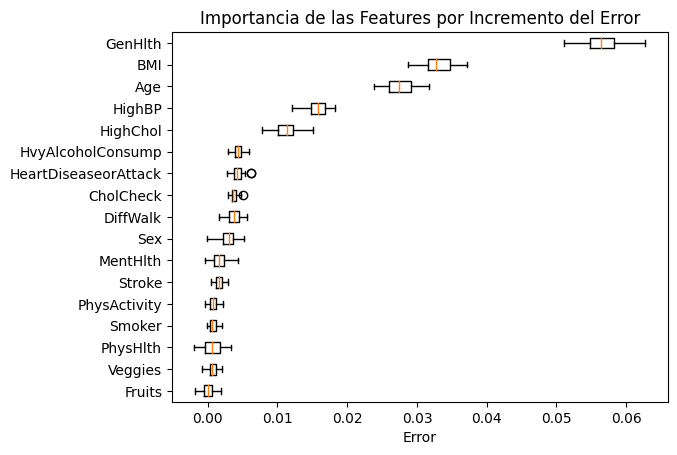

In [12]:
# Se ordena y grafica
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx]
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

El método de permutación tiene como objetivo medir el incremento del error (Feature Importance) en la predicción del modelo después de haber permutado valores en las features. De esta forma, se mide la importancia manteniendo todas las columnas "fijas", a excepción de aquella que es estudiada, a la cual se le reordenan sus elementos para medir si aumenta o no el error del modelo. Si el error aumenta al mezclar sus valores, se considera importante.

Los 5 features que tienen un mayor impacto en la salida del modelo corresponden a *GenHlth*, *BMI*, *Age*, *HighBP* y *HighChol*, respectivamente. Estas características sí tienen sentido en el contexto del problema, puesto que la salud general, el índice de masa corporal, la edad, la presión arterial alta y el colesterol alto son factores conocidos que pueden estar relacionados con el riesgo de desarrollar diabetes.

Al observar los cambios en las conclusiones con respecto a las features importances del punto anterior, se ve que las 5 características que tienen un mayor impacto en la salida del modelo también se encuentran dentro de los tres primeros lugares en al menos uno de los rankings anteriores (weight, cover y gain). No obstante, es importante señalar que los resultados obtenidos mediante el método de permutación pueden diferir de las importancias calculadas por otros métodos. Esta divergencia proporciona una perspectiva distinta sobre la relevancia de las características al evaluar directamente cómo afecta el rendimiento del modelo al alterar los valores de las características. Esta variación en los resultados permite una evaluación alternativa de la importancia de las features desde una perspectiva diferente.

Las ventajas del método son:
1. No necesita re-entrenar el modelo, ya que al método solo le importa la variación de respuesta frente a un mismo modelo.
2. Es de fácil interpretación, porque es sencillo notar cuáles son las variables que un mayor efecto poseen, puesto que se observa directamente con el tamaño del error.
3. Toma en cuenta todas las interacciones, lo que permite ver cómo interactúan las variables con el modelo.

Las desventajas del método son:
1. Puede ser computacionalmente costoso si se realizan muchas permutaciones, especialmente para modelos complejos o conjuntos de datos grandes.
2. Si las features están correlacionadas, se pueden generar sesgos por entradas poco realistas, debido a la naturaleza de este método. Como por ejemplo, que se genere una entrada para una persona con una altura muy grande pero un peso extremadamente pequeño.
3. Está enlazado al error del modelo. Es imposible corroborar cuál es el error si no se tiene acceso a los valores reales de la clasificación.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [13]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [14]:
explainer = shap.TreeExplainer(predictor)
shap_values = explainer(X)
shap_values

[23:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


.values =
array([[ 0.04867445,  0.5144305 ,  0.03071876, ...,  0.343385  ,
         0.08081163,  0.06339891],
       [-0.33966812,  0.42756468,  0.03427808, ...,  0.26038983,
         0.05688414, -0.01610783],
       [ 0.03400585, -0.46763444,  0.02522952, ...,  0.9690932 ,
         0.01450042,  0.05322327],
       ...,
       [-0.01364227,  0.42091724,  0.03083482, ...,  0.07603722,
         0.01375993,  0.22146112],
       [ 0.01360087,  0.5252075 ,  0.03365076, ..., -0.2424677 ,
         0.01513213, -0.00266886],
       [ 0.00982541,  0.44467202,  0.03849592, ..., -0.06207664,
         0.02459943,  0.16299006]], dtype=float32)

.base_values =
array([-0.00636337, -0.00636337, -0.00636337, ..., -0.00636337,
       -0.00636337, -0.00636337], dtype=float32)

.data =
array([[ 0.,  1.,  0., ...,  4.,  0.,  0.],
       [ 1.,  1.,  0., ..., 12.,  0.,  0.],
       [ 0.,  0.,  0., ..., 13.,  0.,  0.],
       ...,
       [ 0.,  1.,  0., ..., 13.,  1.,  1.],
       [ 0.,  1.,  0., ..., 11.,  1.

Dentro del resultado se puede observar el **valor base** (base_values), el cual es el valor esperado de la salida de un modelo de aprendizaje automático si no tuviera información sobre las características y se utiliza como punto de referencia para comprender cómo contribuyen las características de un ejemplo concreto a la predicción del modelo para ese ejemplo. En consecuencia, el valor base es importante para entender los valores SHAP porque proporciona un contexto para interpretar los valores.

Al observar los valores en shape_values, se tiene un valor para cada una de las features con las que fue entrenado el modelo, el cual puede ser positivo o negativo. Los valores negativos señalan aportes negativos para detectar el target de interés, mientras que los positivos señalan variables que entregan un aporte positivo a la detección. De esta manera, cada número en el resultado de los Shap values representa la contribución de una característica específica a la predicción del modelo. 

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

Aporte de las variables para la instancia 1


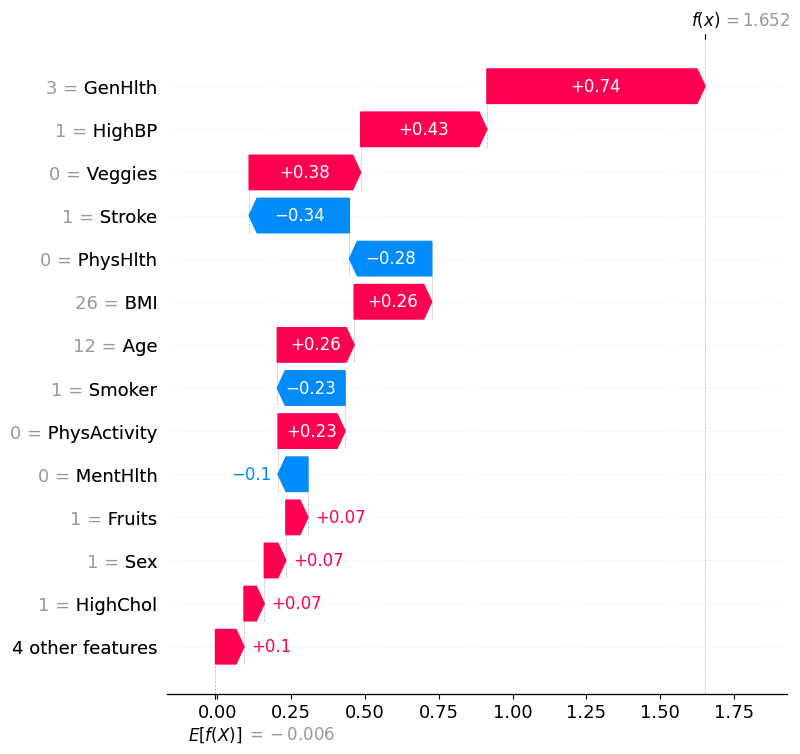

Aporte de las variables para la instancia 9


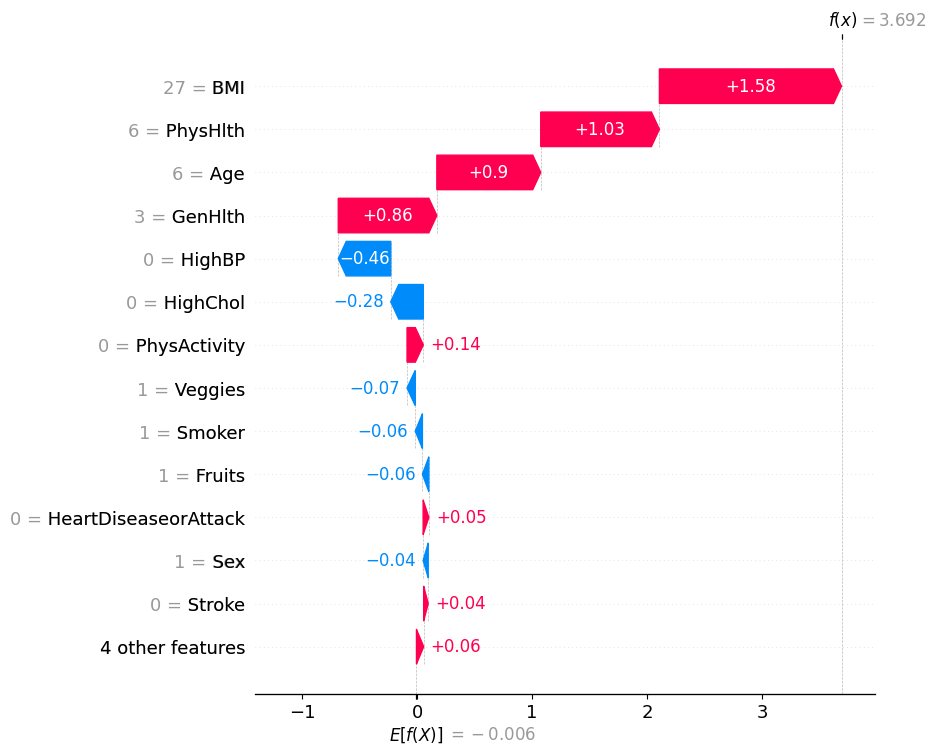

Aporte de las variables para la instancia 150


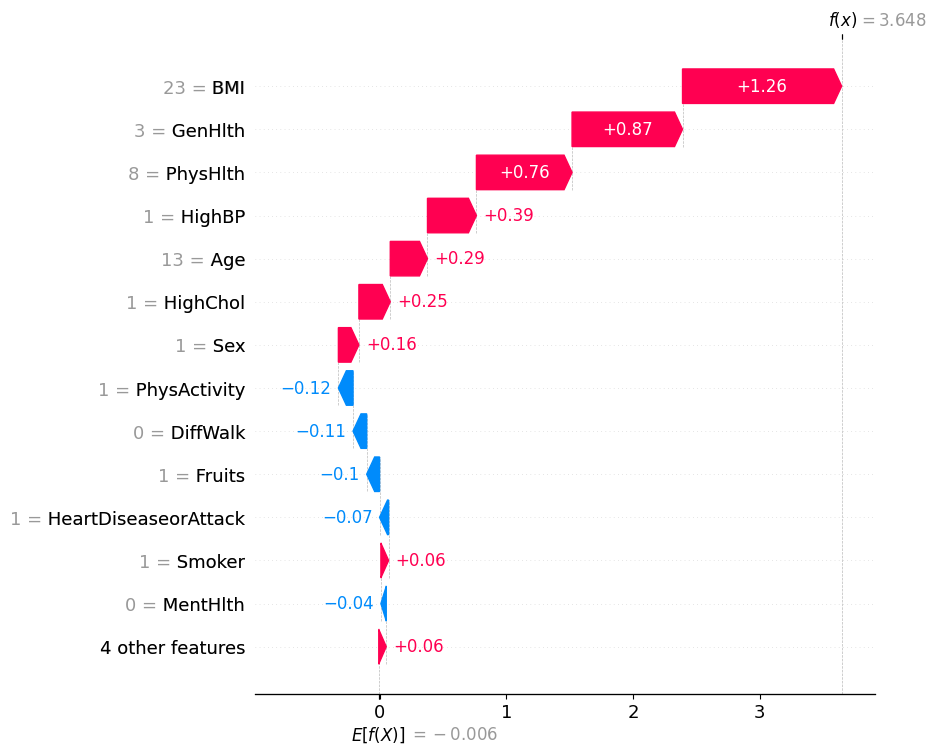

In [15]:
instancias = [1, 9, 150]

for i in instancias:
    print(f"Aporte de las variables para la instancia {i}")
    shap.plots.waterfall(shap_values[i], max_display=14)

`¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?`

Para la instancia 1:

- **Positivas:** destacan las variables GenHlth (+0.74), HighBP(+0.43), Veggies (+0.38), BMI (+0.26), Age (+0.26), PhysActivity (+0.23), Fruits (+0.07), Sex (+0.07) y HighChol (+0.07).
- **Negativas:** Stroke (-0.34), PhysHlth (-0.28), Smoker (-0.23) y MentHlth (-0.01).

Para la instancia 9:

- **Positivas:** destacan las variables BMI (+1.58), PhysHlth (+1.03), Age (+0.9), GenHlth (+0.86), PhysActivity (+0.14), HeartDiseaseorAttack (+0.05) y Stroke (+0.04).
- **Negativas:** HighBP(-0.46), HighChol (-0.28), Veggies (-0.07), Smoker (-0.06), Fruits (-0.06) y Sex (-0.04).

Para la instancia 150:

- **Positivas:** destacan las variables BMI (+1.26), GenHlth (+0.87), PhysHlth (+0.76), HighBP(+0.39), Age (+0.29), HighChol (+0.25), Sex (+0.16) y Smoker (+0.06).
- **Negativas:** PhysActivity (-0.12), DiffWalk (-0.11), Fruits (-0.1), HeartDiseaseorAttack (-0.07) y MentHlth (-0.04).

`¿Existe algún patrón común entre las instancias analizadas?`

El patrón que se observa es que para todas las instancias analizadas GenHlth, BMI y Age son características que afectan de manera positiva a la probabilidad de poseer diabetes, mientras que ninguna de las características afecta negativamente en las 3 instancias. Por otro lado, HighBP, PhysActivity y Sex afectan positivamente en 2 de las 3 instancias; mientras que Smoker, MentHlth y Fruits afectan negativamente a 2 de las 3 instancias.

`¿Es posible generalizar estas conclusiones a todo el dataset?`

De los resultados se observa que en varias de las características cambia su aporte en las diferentes instancias, incluso entre valores positivos y negativos. Además, en cada uno de los gráficos estudiados se tiene que al final se señalan "4 others features", sin mostrar más información al respecto. En consecuencia, no se pueden generalizar estas instancias a todo el dataset, solo se están tomando 3 instancias, pueden suceder que no se esté captando la naturaleza de todas las variables. Es importante realizar un análisis más sólido y representativo de todo el dataset para obtener conclusiones que se puedan generalizar.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

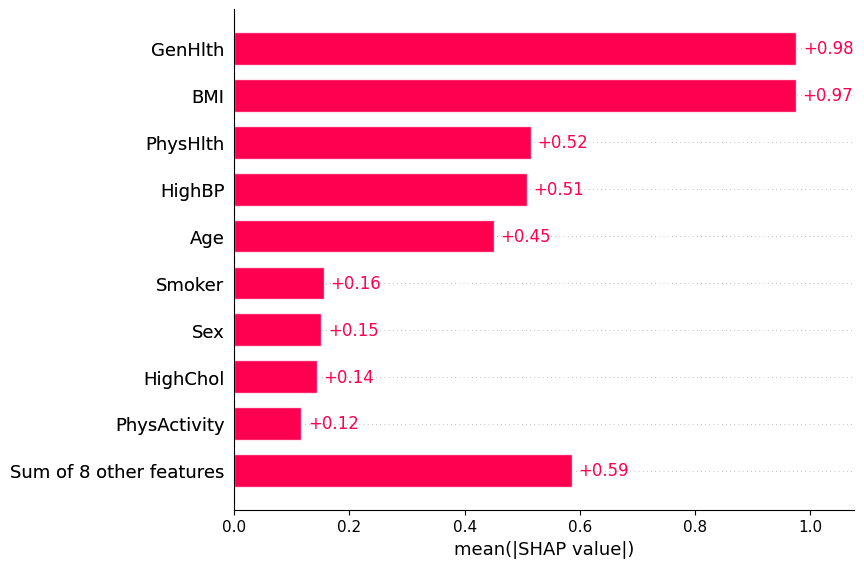

In [16]:
shap.plots.bar(shap_values)

El gráfico recién obtenido representa el impacto promedio de las variables en el conjunto de datos completo, a diferencia de los que se generan a nivel de instancia, puesto que estos se centran en el impacto específico en cada instancia por sí sola.

Al observar el aporte de las variables a nivel global, se ve que las 5 feautures con un mayor aporte corresponden a GenHlth, BMI, PhysHlth, HighBP y Age, respectivamente. De la pregunta anterior, se obtuvo que GenHlth, BMI y Age son las características que afectaron de manera positiva a la probabilidad de poseer diabetes en las 3 distancias estudiadas, las cuales están dentro de las 5 características que un mayor aporte poseen a un nivel global, lo cual tiene sentido. Una de las diferencias que se observa es que solo se ven aportes positivos, mientras que al estudiar las instancias individualmente, sí se observan aportes negativos.

Otro detalle que se nota es que al final del gráfico se indica que la suma de las últimas 8 features tienen un aporte de +0.59. Por lo que a pesar de que estás últimas características tengan un aporte menor por sí solas, en conjunto poseen un aporte que supera a la tercera característica con más aporte (PhysHlth). 

De todas formas, es importante tener en cuenta que este gráfico representa una medida promedio, lo que no implica que captura las variaciones individuales. Pueden existir casos específicos dentro del dataset donde algunas variables tengan un impacto diferente al promedio.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [17]:
# Inserte código para generar gráficos de feature vs shap value aquí
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

# Obtenemos las probabilidades de las predicciones
probabilities = pipeline.predict_proba(X)[:, 1]

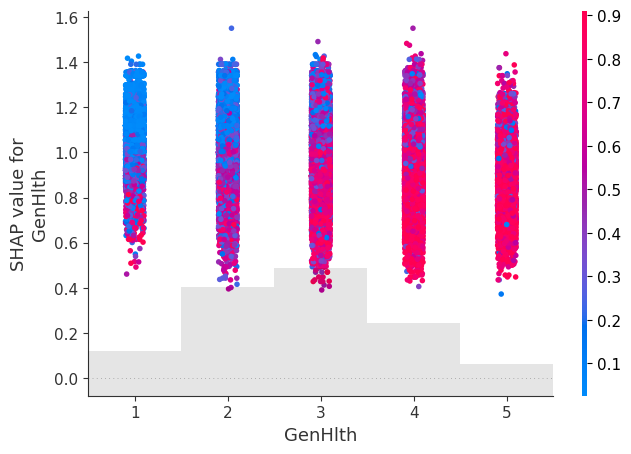

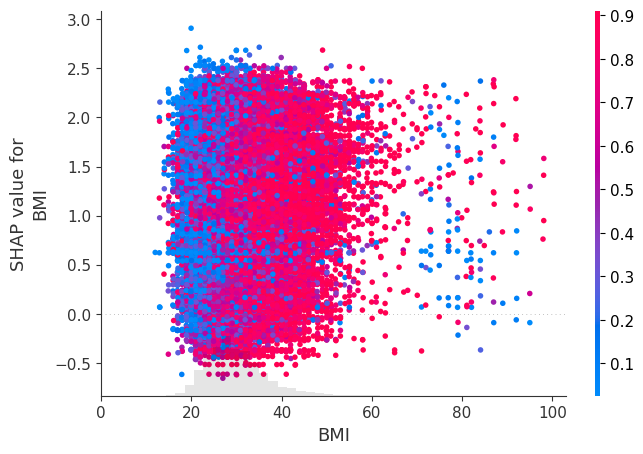

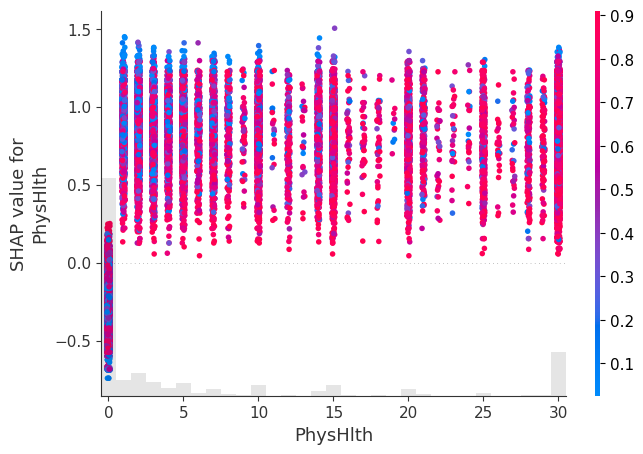

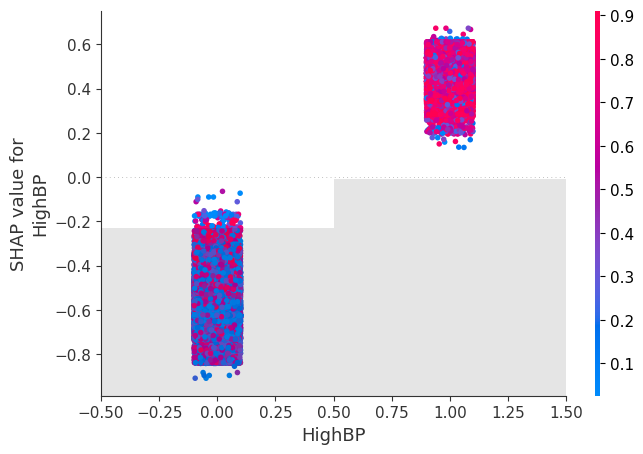

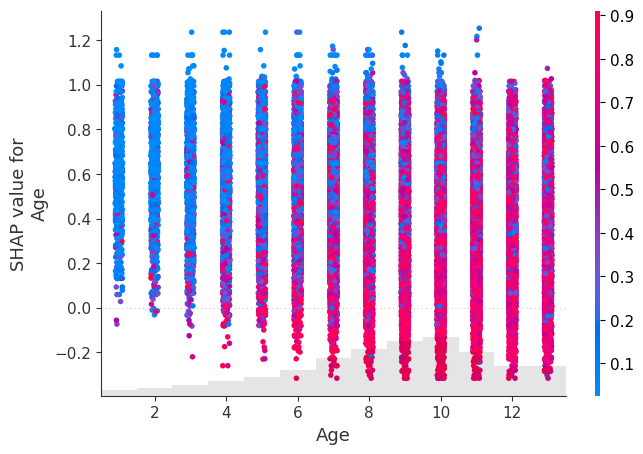

In [18]:
for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], color=probabilities, xmin=0)

Del primer gráfico, para la variable `GenHlth`, se puede desprender que a medida que se avanza en las categorías, aumenta la probabilidad de tener diabetes. Esto indica que mientras más alto sea el número de la categoría, peor es el estado general de salud de la persona, lo que conlleva un mayor riesgo de desarrollar diabetes.

Para la variable `BMI`, Índice de Masa Corporal, en el gráfico se aprecia que mientras más alto sea, existe más riesgo de diabetes, lo cual es coherente con la información médica disponible actualmente. No obstante, es importante notar que al aumentar hacia el valor 80, el gráfico muestra una tendencia a descender la probabilidad de diabetes.

El gráfico de la variable `PhysHlth` nos dice que esta no tiene una influencia en la probabilidad de desarrollar diabetes, ya que las probabilidades están repartidas de manera uniforme, sin ningún tipo de carga hacia algún extremo. Esto indica que el modelo aprendió que salud física no es algo relevante para el diagnóstico de la enfermedad.

La variable `HighBP` muestra en su gráfico una clara tendencia a que el riesgo de diabetes aumenta en las personas con hipertensión, ya que los colores de las probabilidades están muy dividios entre si la persona tiene o no hipertensión. 

Finalmente, el modelo aprendió que la variable `Age` también tiene una influencia en la probabilidad de padecer diabetes, dado que en el gráfico se visualiza un evidente aumento en esta según aumenta la edad. 

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

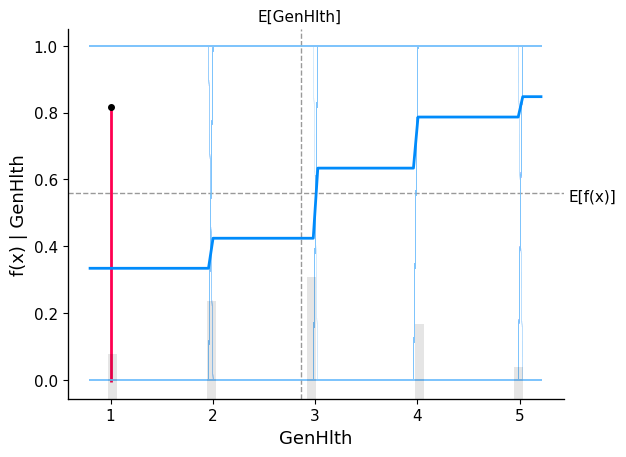

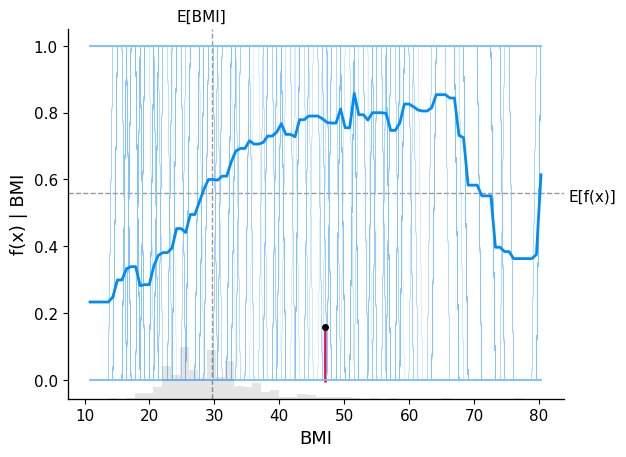

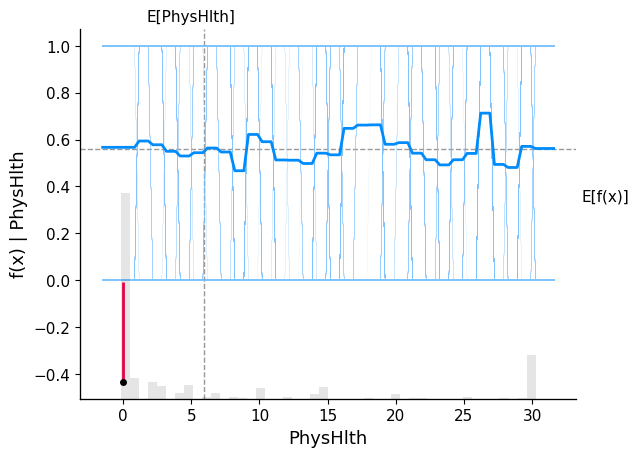

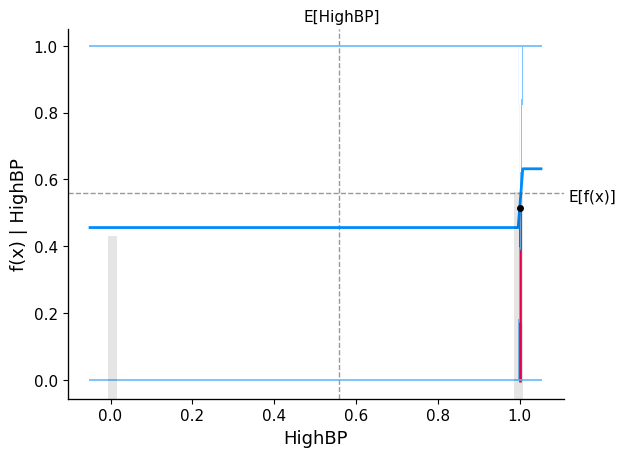

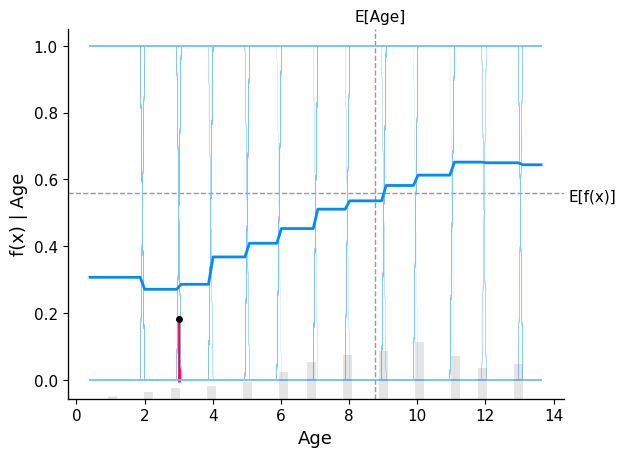

In [39]:
sample_ind = 42
for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
        name, pipeline.predict, shap.utils.sample(X, 1000), model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind:sample_ind+1,:]
    )

Los resultados presentados por los PDP son consistentes con las interpretaciones derivadas de los scatter plot.

Más específicamente, se ve que el PDP de la variable `GenHlth` indica que a medida que se avanza en las posibles categorías, el riesgo de desarrollar diabetes aumenta. 

Además, la probabilidad de diabetes aumenta junto a la variable `BMI`, excepto hacia el valor 80 que empieza a descender. Esto seguramente se debe a que tener un índice de masa corporal tan elevado no es nada común, por lo que hay muchos menos datos y por lo tanto menos posibilidad de diabetes, lo que el modelo interpreta como un descenso en la probabilidad.

Al igual que antes, el PDP de la variable `PhysHlth` indica que la variable no aporta a la predicción de diabetes, ya que oscila alrededor del valor esperado del modelo, pero no muestra una tendencia clara hacia algún extremo.

El PDP dela variable `HighBP`, al ser categórica, muestra claramente un aumento en la probabilidad al pasar de una persona sin hipertensión a una con hipertensión, indicando así una relación entre esta variable y la salida del modelo.

Finalmente, de la variable `Age` se desprende que la edad es un factor de importancia para la diabetes, ya que la probabilidad de desarrollarla aumenta con la edad, excepto de 0 a 2 años. Probablemente, esto se debe a la cantidad de exámenes médicos y diagnósticos que se hacen a un recién nacido con respecto a los que se le hacen a niños de 2 años.

Estos resultados, al ser producidos por una muestra aleatoria de los datos, son generalizables a todos los datos.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [45]:
from alibi.explainers import AnchorTabular

In [ ]:
# Inserte su código para generar sistema de reglas aquí

idx = 1000
# explicar predicción idx 1000

idx = 3001
# explicar predicción idx 3001

idx = 5751
# explicar predicción idx 5751

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>